In [ ]:
import os
import time
from basic_parameters import basic_params
from process import processing_and_save
timer = time.time()
os.system("mpiexec -n 6 python3 base_model.py")
print("Simulation is finished!")
print(time.time() - timer)

file = basic_params["file_results"]
processing_and_save(file)


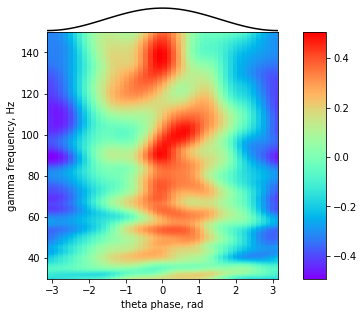

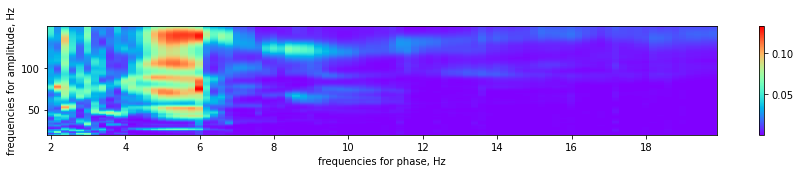

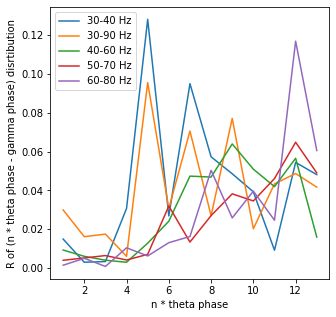

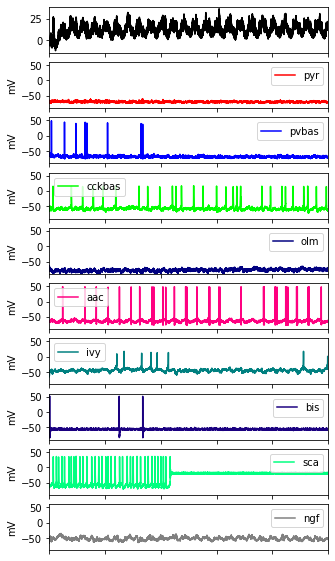

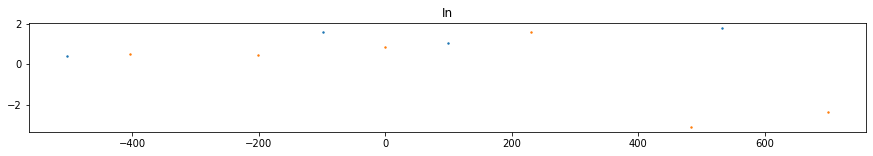

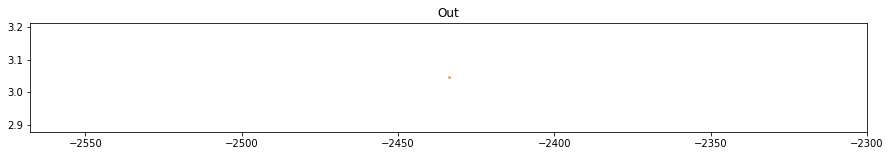

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 2)
# from basic_parameters import basic_params
import plot_result as my_plot

filepath = "../../Data/CA1_simulation/test.hdf5" #  basic_params["file_results"]
# my_plot.plot_v(filepath)

# my_plot.plot_spike_raster(filepath)
# my_plot.plot_lfp(filepath)
# my_plot.plot_phase_disrtibution(filepath)
my_plot.plot_phase_by_amplitude_coupling(filepath)
# my_plot.plot_current_source_density(filepath, "theta")
my_plot.plot_modulation_index(filepath)
my_plot.plot_nm_phase_phase_coupling(filepath)
my_plot.plot_v_vs_pyr_lfp(filepath)
my_plot.plot_phase_precession(filepath)

In [2]:
from process import processing_and_save

file = "../../Data/CA1_simulation/test.hdf5"
processing_and_save(file)



/usr/local/lib/python3.8/dist-packages/elephant/pandas_bridge.py:21: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  warnings.warn("pandas_bridge module will be removed in Elephant v0.8.x",


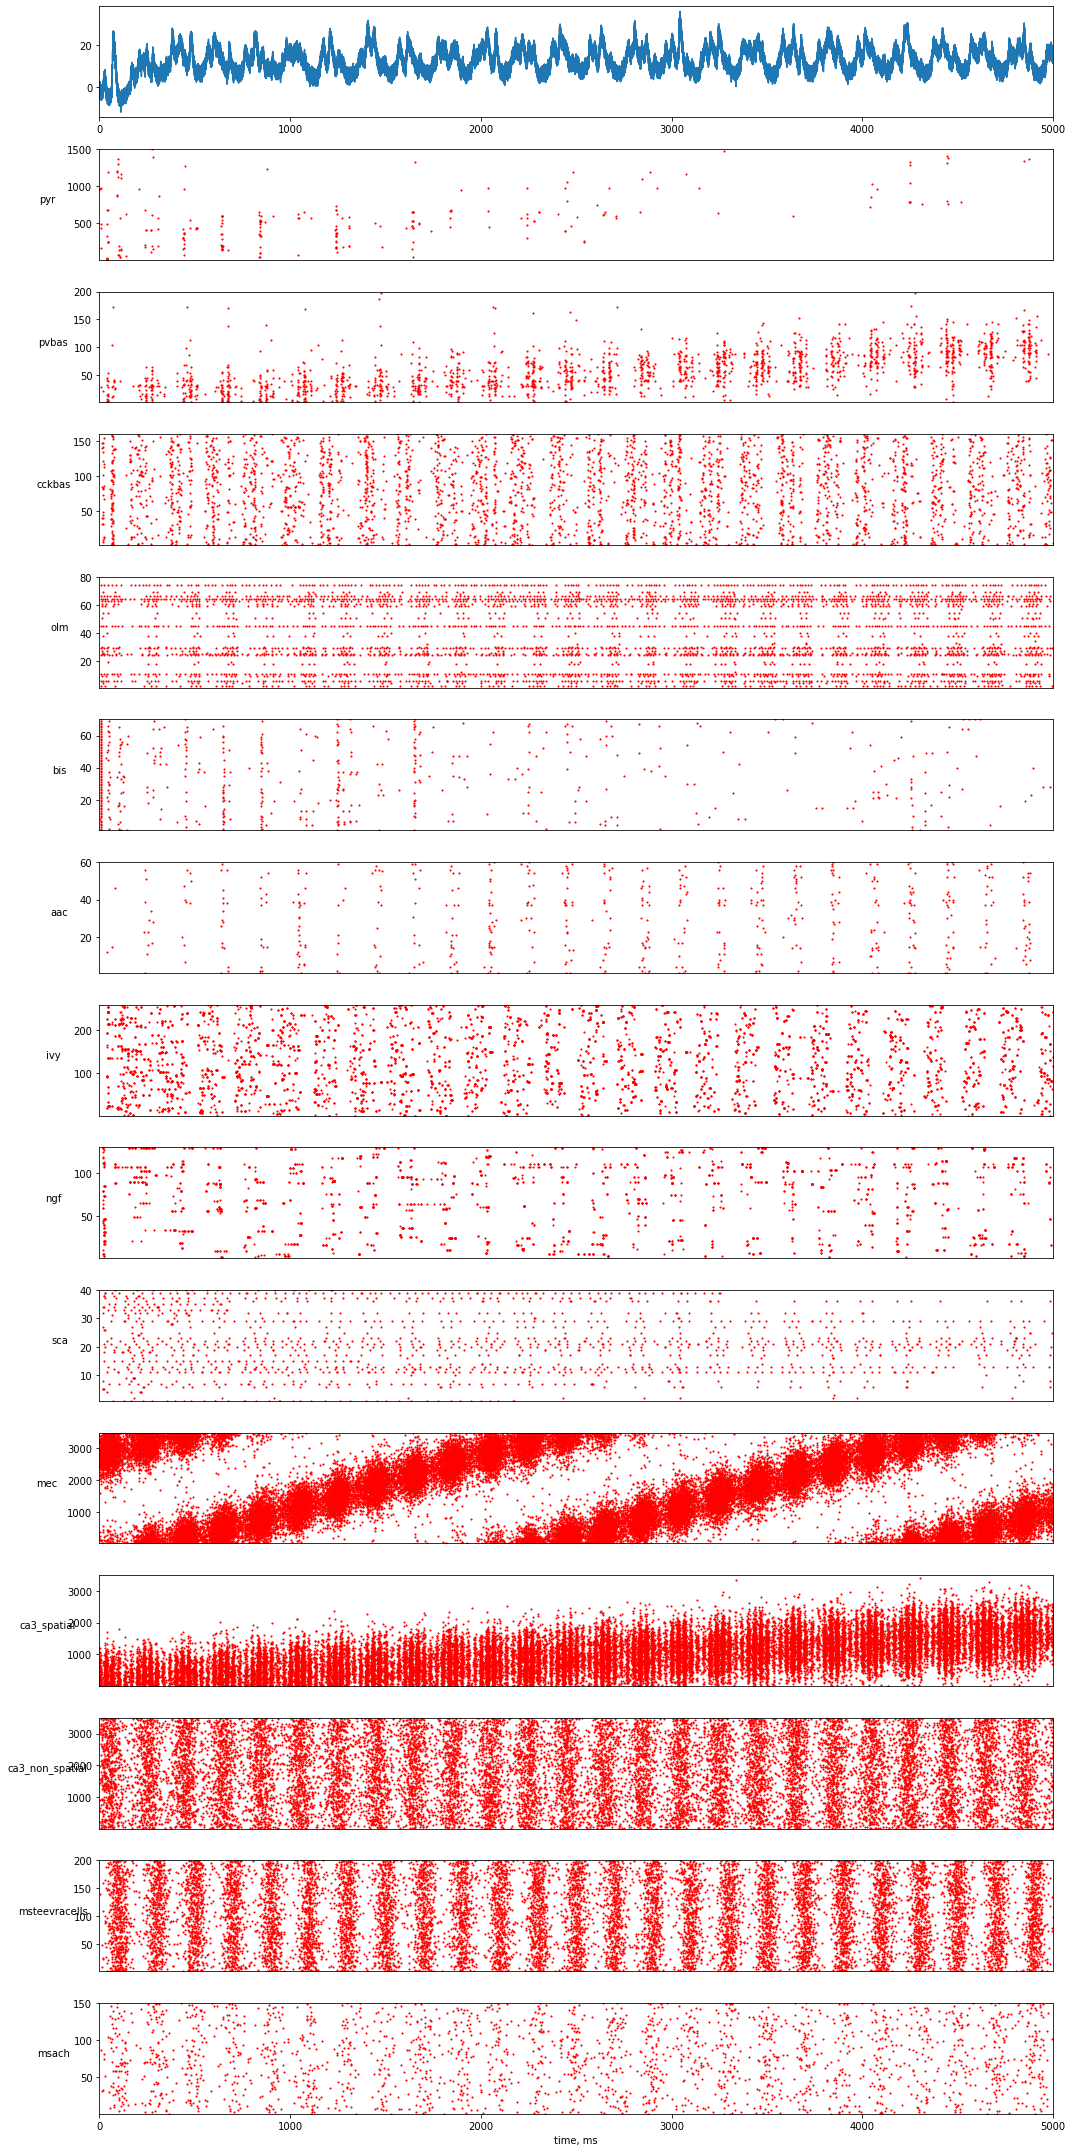

In [1]:
import numpy as np
# from scipy.signal import hilbert
import matplotlib.pyplot as plt
from matplotlib import gridspec
import h5py
# from basic_parameters import basic_params
# import processingLib as proclib
plt.rcParams["figure.figsize"] = (15, 2)

# import plot_result as my_plot
neuron_order = ["pyr", "pvbas", "cckbas", "olm", "bis", "aac", "ivy", "ngf", "sca", "mec", "ca3_spatial", "ca3_non_spatial", "msteevracells", "msach"]

# neuron_order = ["pvbas", "ca3_spatial"]

filepath = "../../Data/CA1_simulation/test.hdf5"   # basic_params["file_results"]
# my_plot.plot_spike_raster(file)

with h5py.File(filepath, 'r') as h5file:
    t0 = h5file["time"][0]
    t1 = h5file["time"][-1]
    
    lfp = h5file["extracellular/electrode_1/lfp/origin_data/channel_1"][:]
    t = np.linspace(t0, t1, lfp.size)
   
    raster_group = h5file["extracellular/electrode_1/firing/origin_data"]
                
    fig = plt.figure(figsize=(15, 30))
        
    neurons_num = len(neuron_order)
    gs = gridspec.GridSpec(neurons_num+1, 1)
    
    axes = plt.subplot(gs[0])
    axes.plot(t, lfp)
    axes.set_xlim(t0, t1)

    for celltype_idx, celltype in enumerate(neuron_order):
   
        try:
            celltype_group = raster_group[celltype]
            axes = plt.subplot(gs[celltype_idx+1])
           
            for sp_idx, (cell_key, firing) in enumerate(celltype_group.items()):
                sp_idx += 1
                axes.scatter(firing,  np.zeros(firing.size) + sp_idx, s=1.2, color="red" )

            axes.set_ylim(1, sp_idx)
            axes.set_xlim(t0, t1)
            axes.set_ylabel(celltype, rotation='horizontal', labelpad=20)

            if celltype_idx == len(neuron_order) - 1:
                axes.set_xlabel("time, ms")
            else:
                axes.tick_params(labelbottom=False, bottom=False)
        except KeyError:
            continue
fig.tight_layout()
plt.show()

In [ ]:
print("hello")

In [ ]:
Npyr = 3000
pyr_coord_x = np.cumsum( np.zeros(Npyr) + 3 )
pyr_coord_x[pyr_coord_x.size//2:] = np.nan
#print(pyr_coord_x[1000:1500])